# Lecture 5 - Contextual Newsvendor / Orange Juice Example

In the previous notebook, we saw the "basic" newsvendor problem, where our data consists simply of previous demand observations. We are now going to turn our attention to the contextual newsvendor problem, where we have to solve the newsvendor problem in the presence of auxiliary contextual information.

The specific dataset that we are going to see is a data set on orange juice sales. This dataset comes from Dominick's Finer Foods, a now defunct chain of grocery stores in the greater Chicago, IL area. (You may have encountered this dataset in Prof. Rossi's class; it is a part of a larger dataset included with the `bayesm` package for R.)

The contextual newsvendor problem that we wish to solve here is to determine a weekly, store-level order quantity decision for a single product. The product is Tropicana Premium Orange Juice, in 64oz size. The product retails for $p = $ \\$3 per unit, and the order cost is $c = 0.7p = $ \\$2.10 per unit.

There are 83 different stores in this chain. These stores differ in a number of demographic covariates:

|Attribute|Description|
|-|-|
|AGE60|Percentage of the population aged 60 or older|
|EDUC|Percentage of the population that has a college degree|
|ETHNIC|Percentage of the population that is black or hispanic|
|INCOME|Median income of the ZIP code of the store|
|HHLARGE|Percentage of households with 5 or more persons|
|WORKWOM|Percentage of women with full-time jobs|
|HVAL150|Percentage of households worth more than $150,000|
|SSTRDIST|Distance to the nearest warehouse store|
|SSTRVOL|Ratio of sales of this store to the nearest warehouse store|
|CPDIST5|Average distance in miles to the nearest 5 supermarkets|
|CPWVOL5|Ratio of sales of this store to the average of the nearest five stores|

Our goal is to be able to take the demographic attributes of a store, and come up with a recommendation of the weekly order quantity. 

We will use the conditional quantile method, which requires us to first build a model to predict demand as a function of these covariates, use that model to create a conditional distribution of demand given a specific set of covariates, and to finally use the conditional distribution to get the optimal newsvendor order quantity. 


## Setting up the data

The first thing we will do is load the data. The following commands will load pandas and numpy for us, and then separate the data into an X and a y array, which we will later use to build the machine learning model.

In [1]:
import pandas as pd
import numpy as np

OJ_df = pd.read_csv("OJ.csv")

# print(OJ_df.head())

OJ_columns = OJ_df.columns
print(OJ_columns)

OJ_columns = OJ_columns[3:] # leave off the store id, week and demand.
X = OJ_df[ OJ_columns ]
X = np.asarray(X)

y = OJ_df[ "demand" ]
y = np.asarray(y)

print(OJ_columns)

Index(['store', 'week', 'demand', 'AGE60', 'EDUC', 'ETHNIC', 'INCOME',
       'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5',
       'CPWVOL5'],
      dtype='object')
Index(['AGE60', 'EDUC', 'ETHNIC', 'INCOME', 'HHLARGE', 'WORKWOM', 'HVAL150',
       'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5'],
      dtype='object')


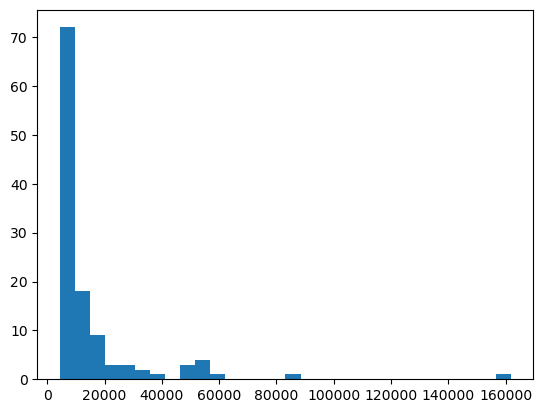

In [2]:
temp = np.asarray(OJ_df)
relinds = temp[:,0] == 3 
temp2 = temp[relinds,2]

import matplotlib.pyplot as plt
plt.hist(temp2, bins = 30)
plt.show()

Next, we are going to load a particular module of scikit-learn to split the data. 

Recall from your earlier courses that when building an ML model, we typically split the data into a _training_ set and a _testing_ set. The goal of the training set is to use it to build the model, whereas the test set is used for testing the model, and evaluating how well the model does on new, unseen data. 

You have probably seen this type of idea in the context of evaluating predictive performance (e.g., calculating the out-of-sample $R^2$ of a linear regression model). You will see shortly that the same idea can be used to evaluate the quality of data-driven decisions. In our case, we wish to evaluate the average out-of-sample profit. 

In [3]:
# Load the model_selection module
import sklearn.model_selection as ms

# Set the random seed
np.random.seed(101)

# Split the data. 
# train_size specifies what fraction of the data is allotted to the training set.
# It is common to see about 50% - 80% of the data being used for training, and the 
# remaining 20-50% being used for testing. 
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, train_size = 0.7)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6754, 11)
(2895, 11)
(6754,)
(2895,)


We will now estimate a machine learning model on this training set. We will use a regression tree model. For this, we will use the `tree` module of scikit-learn.

In [4]:
# Load the tree module
import sklearn.tree as tree

# Estimate the regression tree model
oj_tree = tree.DecisionTreeRegressor(max_depth = 2)
oj_tree = oj_tree.fit(X_train,y_train)

# Inspect the oj_tree object
oj_tree

DecisionTreeRegressor(max_depth=2)

The output we see from looking at `oj_tree` is not particularly informative. It is more helpful to plot the tree, which we can do using the `graphviz` package. 

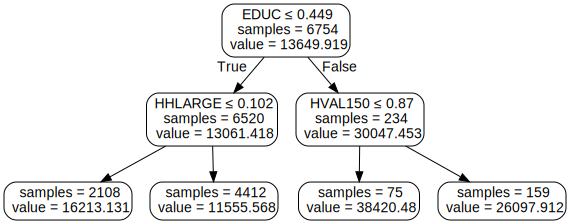

In [5]:
# We will use the graphviz library to plot the tree:
import graphviz 
dot_data = tree.export_graphviz(oj_tree, out_file=None,
                                feature_names=OJ_columns, impurity = False, 
                                   rounded=True,  
                                  special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("OJ") 
graph

## Looking Under the Hood

Have you ever wondered how a regression or classification tree is internally stored? 

The topology of a regression or a classification tree, such as the one above, is a _binary_ tree: each node in the tree has at most two child nodes. To specify it, we need to specify for each node what the left and right child nodes are. 

When you fit a tree using `DecisionTreeRegressor`, you can access the `.tree_.children_left` and `.tree_.children_right` attributes to extract the topology:

In [6]:
# oj_tree.tree_.children_left
# oj_tree.tree_.

print(oj_tree.tree_.children_left)
print(oj_tree.tree_.children_right)

[ 1  2 -1 -1  5 -1 -1]
[ 4  3 -1 -1  6 -1 -1]


What do these numbers mean? 

Notice that each array is of size 7:

In [7]:
print(len(oj_tree.tree_.children_left))
print(len(oj_tree.tree_.children_right))

7
7


The number 7 is the number of nodes in the tree. The first node, node 0, is the root of the tree. The numbers in `tree_.children_left` give the index of the node that is the left child. For example:

In [8]:
print(oj_tree.tree_.children_left[0]) # index of left child of node 0 => 1
print(oj_tree.tree_.children_left[1]) # index of left child of node 1 => 2
print(oj_tree.tree_.children_left[2]) # index of left child of node 2 => -1

1
2
-1


In the above, -1 shows up because node 2 has no children -- it is a leaf!

The numbers in `tree_.children_right` have a similar meaning.

In [9]:
print(oj_tree.tree_.children_right[0]) # index of right child of node 0 => 4
print(oj_tree.tree_.children_right[1]) # index of right child of node 1 => 3
print(oj_tree.tree_.children_right[2]) # index of right child of node 2 => -1

4
3
-1


It is perhaps easier to understand it if we draw out how the node indices are connected together:

<!-- ![tree_example.png](attachment:tree_example.png) -->

<img src="http://vvmisic.github.io/msba408/tree_example.png" alt="Tree topology" style="width: 200px;"/>


This is useful to know, because now we know the indices of the leaves. We will use this to construct our newsvendor quantiles for each leaf.

## Getting the decision for each leaf

Now that we know how the leaves are numbered we can make sense of the `apply` function:


In [10]:
# temp = oj_tree.predict(X_train)
# print(temp)
leaf_mapping = oj_tree.apply(X_train)
leaf_mapping
print([leaf_mapping[i] for i in range(len(leaf_mapping))])

[2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 6, 3, 3, 2, 2, 3, 3, 5, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 5, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 6, 2, 6, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 6, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 5, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 5, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 

What this function does is that it basically runs each observation in `X` down the tree, and returns the index of the leaf in which it lands. For example, observation 50 is mapped to leaf 3:

In [11]:
print(leaf_mapping[49])

print(OJ_columns)
print(X_train[49,])
# EDUC = 0.04955
# HHLARGE = 0.216
# HVAL150 = 0.01111

3
Index(['AGE60', 'EDUC', 'ETHNIC', 'INCOME', 'HHLARGE', 'WORKWOM', 'HVAL150',
       'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5'],
      dtype='object')
[ 0.13699514  0.04955029  0.5640868  10.0365751   0.21635434  0.26723395
  0.01111797  8.36953499  1.11538462  2.10982435  0.19768396]


For each leaf, we can use this to determine the corresponding newsvendor quantile:

In [12]:
leaves = [i for i in range(oj_tree.tree_.node_count) if oj_tree.tree_.children_left[i] == -1 ]
print(leaves)

leaf_to_quantile = np.zeros( oj_tree.tree_.node_count )

p = 3.00
c = 0.7 * p # 2.10
nv_quantile = (p - c)/p 
print(nv_quantile)

for ell in leaves: # for each leaf, calculate quantile value of conditional distribution
    ind = leaf_mapping == ell #boolean list 
    y_ell = y_train[ind] # only the y values that are in the leaf node
    leaf_to_quantile[ell] = round(np.quantile(y_ell, nv_quantile))
    
leaf_to_quantile

[2, 3, 5, 6]
0.3000000000000001


array([    0.,     0.,  7424.,  4800.,     0., 17203., 13376.])

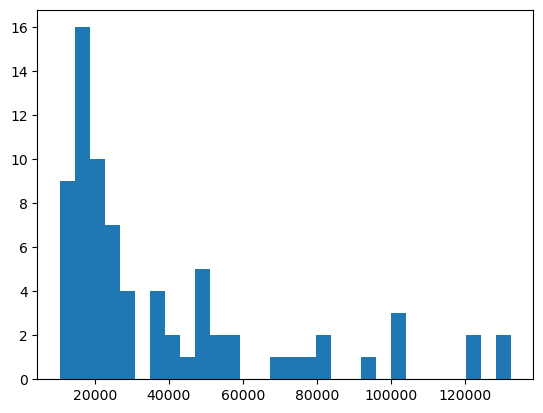

In [13]:
ell = 5 # try 2, 3, 5, 6 #plotting conditional distributions for each leaf node
ind = leaf_mapping == ell 
y_ell = y_train[ind]

import matplotlib.pyplot as plt 
plt.hist(y_ell, bins = 30)
plt.show()

In [2]:
# Some stores are going to be similar, we will pool their 
# conditional distributions together and calculate the percentile of the pooled data.

This now gives us an implementable rule!

<!-- :
- For a given store, if its covariates are such that it gets mapped to leaf 2, then order 7424 units;
- If it is mapped to leaf 3, order 4800 units;
- If it is mapped to leaf 5, order 17203 units;
- If it is mapped to leaf 6, order 13376 units. -->

## Out of sample evaluation

Let's now see what our out-of-sample profit would be; this is where we can use the test data.

Recall that our test data consists of 2895 week-store demand observations. What we need to do is the following:
- Map each test set observation using our tree (`oj_tree`) to the corresponding leaf.
- Look up the quantile corresponding to that leaf.
- Calculate the profit using the formula $p \min(Q, D) - cQ$.
- Average over all of the test set observations.

In [14]:
test_set_leaves = oj_tree.apply(X_test)
print(test_set_leaves[0:10])

test_set_decisions = leaf_to_quantile[test_set_leaves]
print(test_set_decisions)

test_set_profit = p * np.minimum(test_set_decisions, y_test) - c * test_set_decisions #element-wise minimum, 
avg_test_set_profit = test_set_profit.mean(axis = 0)
print("Average out-of-sample profit (contextual newvendor):", avg_test_set_profit) #per store, per week

[6 3 2 2 3 2 3 3 2 3]
[13376.  4800.  7424. ...  4800. 13376.  4800.]
Average out-of-sample profit (contextual newvendor): 4028.04113990718


So we on average have a profit of \\$4028 (per week, per store) where we are averaging over the 2895 week-store observations in the test set. 

As a comparison, let's see see what happens if we just treat all the stores as the same, and choose the same order quantity for all of them, using the ordinary newsvendor model from the previous notebook.

In [15]:
# Find the optimal ordinary newsvendor order quantity:
optimal_Q_nv = np.quantile(y_train, nv_quantile)
print("Optimal ordinary newsvendor order quantity is: ", optimal_Q_nv) #assuming all data is the same, ignoring all demographics

# Now calculate what our profit would be, for each store and week combination in the test data:
# Profit = p * min(Q,D) - cQ
test_set_profit_ordinary = p * np.minimum(optimal_Q_nv, y_test) - c * optimal_Q_nv
avg_test_set_profit_ordinary = test_set_profit_ordinary.mean(axis = 0)
print("Average out-of-sample profit (ordinary newsvendor):", avg_test_set_profit_ordinary) 
#makes sense it is lower tham 4028 because if you consider all of them to be the same, 
#you find one order quantity that fits all which might not be optimal, 
#but when you find different order quantities for different stores, 
#there is more leeway for customised fitting.

Optimal ordinary newsvendor order quantity is:  5696.00000004664
Average out-of-sample profit (ordinary newsvendor): 3639.7430051667343


Notice that if we select one order quantity for all of the stores, our profits suffer. The reason for this is that the stores are different. As we saw from the regression tree, the average demand varies with the demographic attributes. 